/tmp/ipython-input-1979288678.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift = results.groupby('Decile')['Actual'].mean().sort_index(ascending=False)


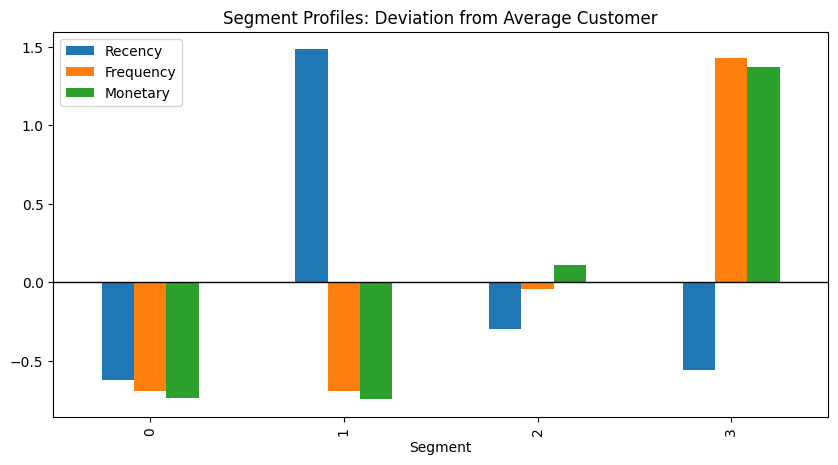

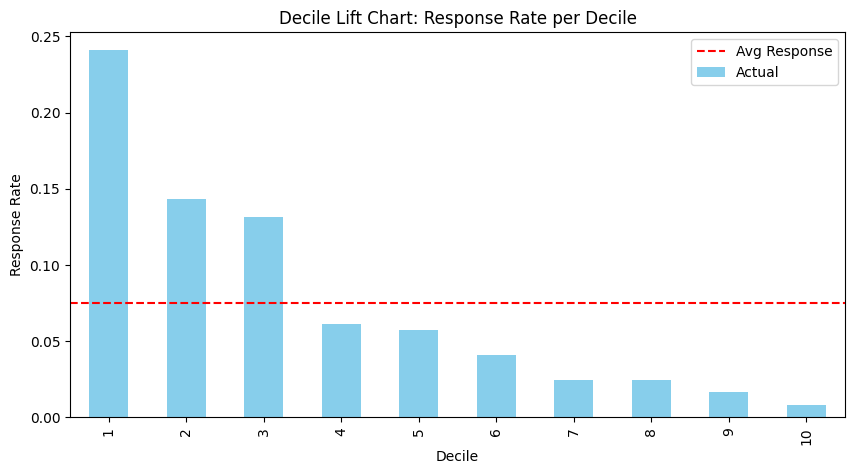

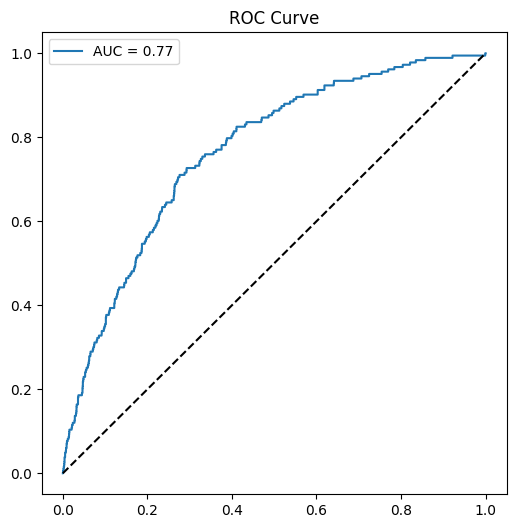

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score


colspecs = [
    (0, 10), (10, 24), (24, 34), (34, 35), (35, 42), (42, 43), (43, 50),
    (50, 64), (64, 72), (72, 80), (80, 88), (88, 96), (96, 104), (104, 112),
    (112, 122), (122, 130), (130, 131), (131, 132), (132, 133), (133, 134),
    (134, 135), (135, 138), (138, 139), (139, 147), (147, 148), (148, 156),
    (156, 157), (157, 161), (161, 162), (162, 163), (163, 164), (164, 165),
    (165, 179), (179, 187), (187, 189), (189, 190), (190, 197), (197, 205),
    (205, 207), (207, 234), (234, 241), (241, 246), (246, 247), (247, 248)
]

names = [
    "CORDR-ID", "ORDER-NUM", "DATE", "SUBS-IND", "SUBS-QTY", "CAT-IND", "CAT-QTY",
    "RECIPIENTS", "REVENUE", "SHIPPING", "TAX", "CANCEL", "RETURN", "AR",
    "REFUND-DATE", "REFUND-AMT", "REFUND-STAT", "REFUND-TYPE", "REFUND-REASON",
    "OFFER-TYPE", "OFFER-DROP", "OFFER-CODE", "GIFT-CERT-IND", "GIFT-CERT-AMT",
    "COUPON-IND", "COUPON-AMT", "GIFT-IND", "PAY-TYPE", "PAY-CAT", "PAY-STAT",
    "ORD-TYPE", "ANC-IND", "ANC-QTY", "ADD-CHG", "ADD-CHG-CODE", "WED-IND",
    "WEB-QTY", "WRITE-OFF", "DIV", "INDIVIDUAL-ID", "RANK-DATE", "ZIP", "CR", "LF"
]


df = pd.read_fwf("Data Set 8 DMEF0509_text.txt", colspecs=colspecs, names=names)
df['DATE'] = pd.to_datetime(df['DATE'])


# Use 2007-01-01 as a cutoff, history (predictors) vs future (target)
cutoff = pd.Timestamp('2007-01-01')
history = df[df['DATE'] < cutoff]
future = df[df['DATE'] >= cutoff]

# 1 if customer purchased in 2007 or later, else 0
responders = future['CORDR-ID'].unique()

# Aggregate history into RFM Metrics per Customer
rfm = history.groupby('CORDR-ID').agg({
    'DATE': lambda x: (cutoff - x.max()).days,
    'ORDER-NUM': 'count',
    'REVENUE': 'sum'
}).rename(columns={'DATE': 'Recency', 'ORDER-NUM': 'Frequency', 'REVENUE': 'Monetary'})

rfm['Target'] = rfm.index.isin(responders).astype(int)


# Segmentation (Cluster Analysis)
scaler_clust = StandardScaler()
rfm_scaled = scaler_clust.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)


# Logistic Regression
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Target']

# Train/Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling features for modeling
scaler_mod = StandardScaler()
X_train_scaled = scaler_mod.fit_transform(X_train)
X_test_scaled = scaler_mod.transform(X_test)

# Train Model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Visualizations

# A. Segment Profiles (How clusters differ)
profile = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()
profile_std = (profile - profile.mean()) / profile.std()
profile_std.plot(kind='bar', figsize=(10, 5))
plt.title('Segment Profiles: Deviation from Average Customer')
plt.axhline(0, color='black', lw=1)
plt.savefig('segment_profiles.png')

# B. Decile Lift Chart (Model Efficiency)
results = pd.DataFrame({'Actual': y_test, 'Prob': probs})
results['Decile'] = pd.qcut(results['Prob'], 10, labels=np.arange(10, 0, -1))
lift = results.groupby('Decile')['Actual'].mean().sort_index(ascending=False)
plt.figure(figsize=(10, 5))
lift.plot(kind='bar', color='skyblue')
plt.axhline(y_test.mean(), color='red', linestyle='--', label='Avg Response')
plt.title('Decile Lift Chart: Response Rate per Decile')
plt.ylabel('Response Rate')
plt.legend()
plt.savefig('decile_lift.png')

# C. ROC Curve (Model Performance)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')